In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

from IPython.display import clear_output

In [2]:
import fulu
import utils
from binned_split import binned_train_test_split
from copy import deepcopy

/Users/mikhail/opt/anaconda3/envs/fulu/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from joblib import Parallel, delayed

In [4]:
import warnings
# warnings.filterwarnings("ignore")

# Read data

In [5]:
data = pd.read_csv('../data/ANTARES_NEW_10_in_g_r_bands.csv')

In [6]:
data.head()

,Unnamed: 0,object_id,mjd,passband,flux,flux_err,obj_type,peak_time
0,0,ZTF21abxdact,59459.475752,1,0.089995,0.005935,SN Ia,59465.47
1,1,ZTF21abxdact,59461.443414,0,0.038581,0.006491,SN Ia,59465.47
2,2,ZTF21abxdact,59461.471655,1,0.096936,0.007478,SN Ia,59465.47
3,3,ZTF21abxdact,59463.402813,1,0.095471,0.006732,SN Ia,59465.47
4,4,ZTF21abxdact,59463.436470,0,0.040974,0.006084,SN Ia,59465.47


In [7]:
object_ids = np.unique(data.object_id)

In [8]:
passband2name = {0: 'g', 1: 'r'}
passband2lam  = {0: np.log10(4741.64), 1: np.log10(6173.23)}

In [9]:
len(passband2name)

2

# Utils

In [10]:
def get_object(data, object_id):
    anobject = data[data.object_id == object_id].copy()
    return anobject

In [11]:
def get_passband(anobject, passband):
    light_curve = anobject[anobject.passband == passband]
    return light_curve

In [12]:
def add_log_lam(anobject):
    passbands = anobject.passband.values
    log_lam = [passband2lam[i] for i in passbands]
    anobject.loc[:, 'log_lam'] = log_lam
    return anobject

In [13]:
def is_good(anobject):
    
    # remove all objects with negative flux values
    if anobject['flux'].values.min() < 0:
        return 0
    
    # keep only objects with at least 7 observations in at least 3 passbands
    count = 0
    for passband in range(2):
        if len(get_passband(anobject, passband)) < 10:
            count += 1
    if count > 0:
        return 0
        
    # keep only objects without large breaks in observations
    # anobject = anobject.sort_values('mjd')
    # mjd = anobject['mjd'].values
    # if np.diff(mjd, 1).max() > 50:
    #     return 0
    
    return 1

# Visualization

In [14]:
def plot_light_curves(anobject, title="", is_plot=True):
    anobject = anobject.sort_values('mjd')
    plt.figure(figsize=(9, 5.5))
    for passband in range(len(passband2name)):
        light_curve = get_passband(anobject, passband)
        if is_plot:
            plt.plot(light_curve['mjd'].values, light_curve['flux'].values, linewidth=0.5)
        plt.scatter(light_curve['mjd'].values, light_curve['flux'].values, label=passband2name[passband], linewidth=1)
    plt.xlabel('Modified Julian Date', size=20)
    plt.xticks(size=18)
    plt.ylabel('Flux', size=20)
    plt.yticks(size=18)
    plt.legend(loc='best', ncol=3, fontsize=18)
    plt.title(title, size=18)

In [15]:
def plot_light_curves_with_sigma(t, flux, flux_err, passband, title=""):
    colors = ['C'+str(i) for i in range(len(np.unique(passband)))]
    plt.figure(figsize=(9, 5.5))
    for i, pb in enumerate(np.unique(passband)):
        plt.plot(t[passband == pb], flux[passband == pb], linewidth=2., color=colors[i])
        plt.fill_between(t[passband == pb], 
                         flux[passband == pb]+1*flux_err[passband == pb], 
                         flux[passband == pb]-1*flux_err[passband == pb], label=passband2name[pb], alpha=0.5, color=colors[i])
    plt.xlabel('Modified Julian Date', size=20)
    plt.xticks(size=18)
    plt.ylabel('Flux', size=20)
    plt.yticks(size=18)
    plt.legend(loc='best', ncol=3, fontsize=18)
    plt.title(title, size=18)

ZTF17aaazdba


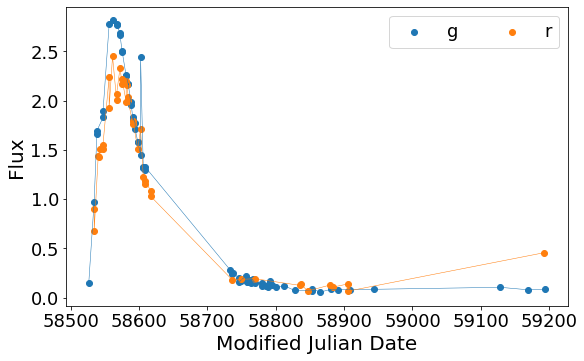

ZTF17aadlxmv


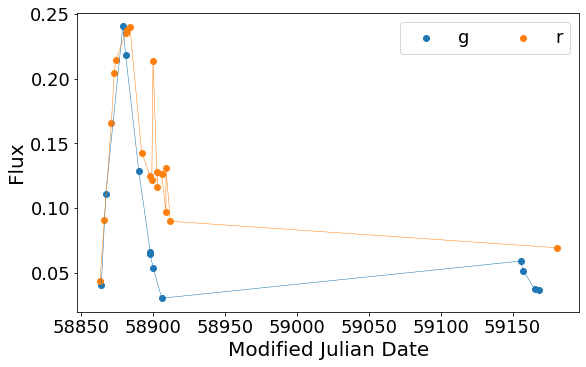

ZTF18aaaibml


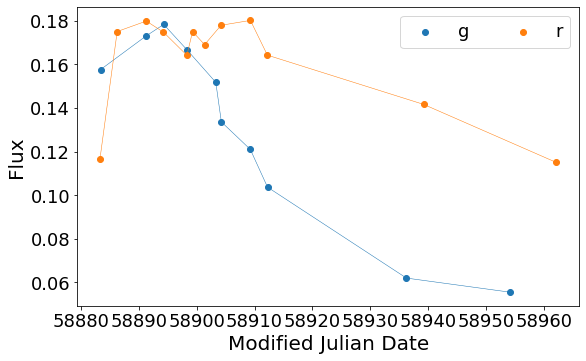

ZTF18aadzfso


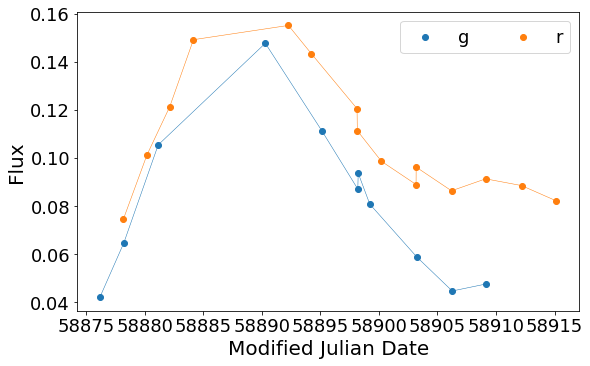

ZTF18aahatvc


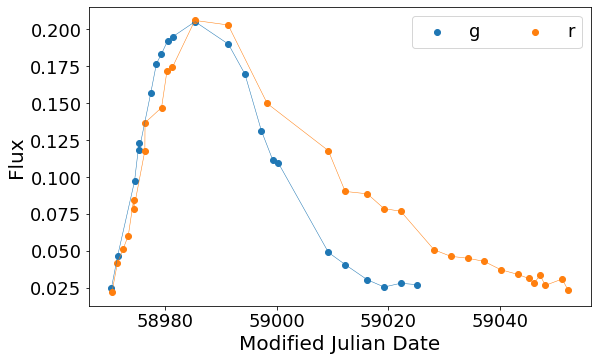

ZTF18aahfbqp


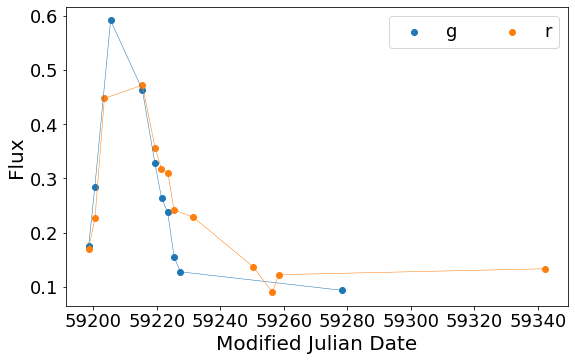

ZTF18aahtjsc


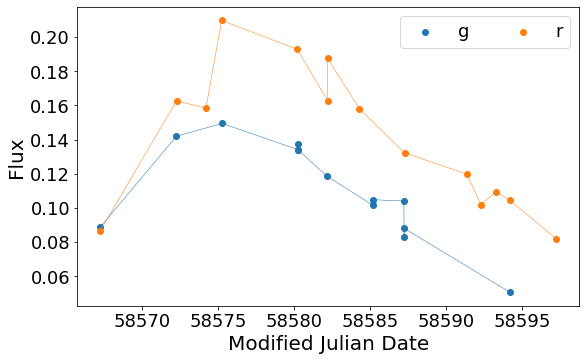

ZTF18aahvndq


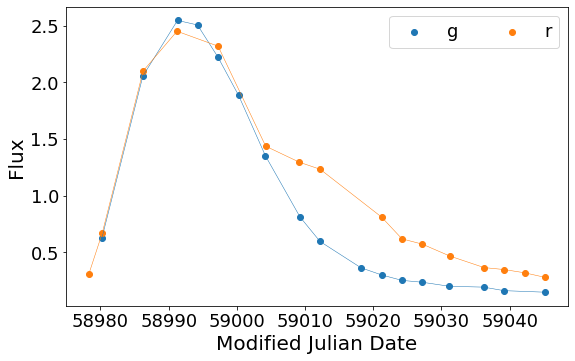

ZTF18aailmnv


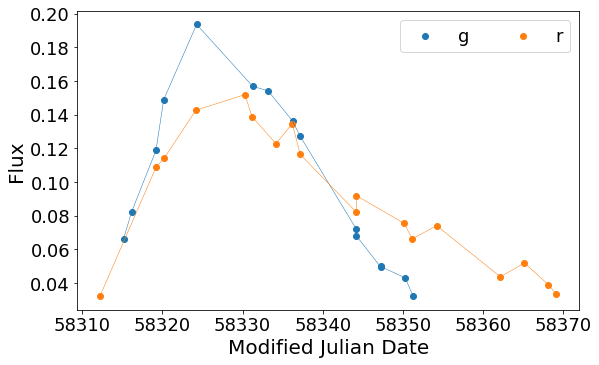

ZTF18aaisqmw


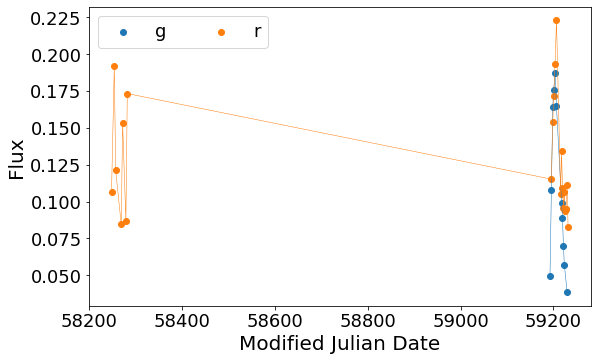

ZTF18aaiykoz


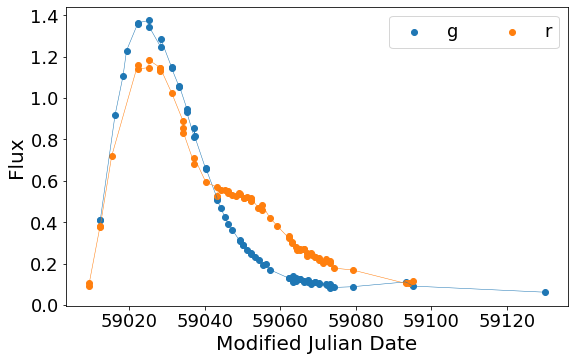

ZTF18aajivpr


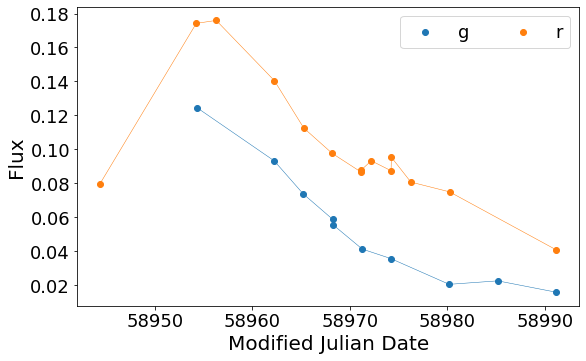

ZTF18aajpjdi


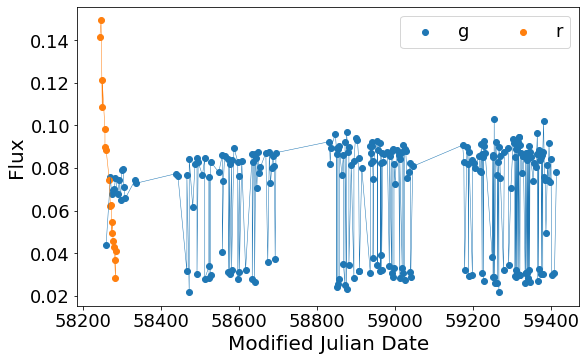

ZTF18aakiwbs


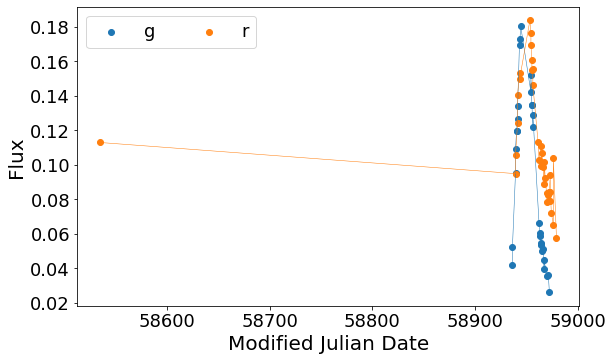

ZTF18aakkrjm


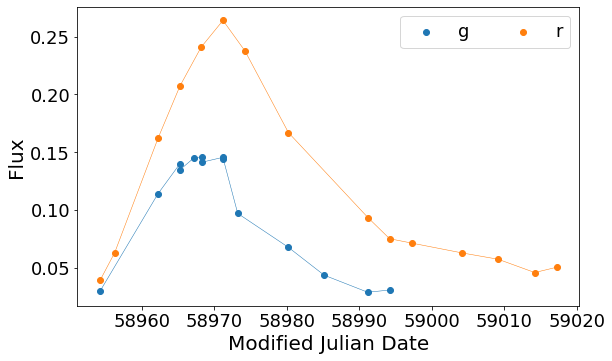

ZTF18aaklpdo


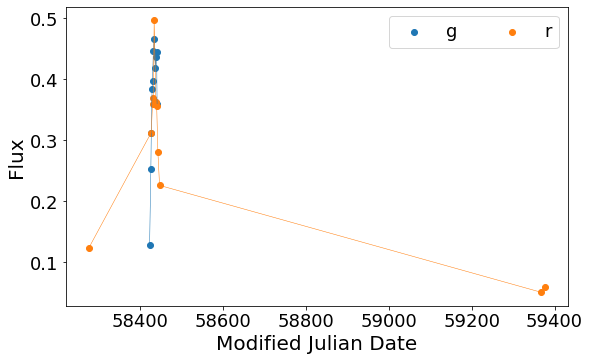

ZTF18aansqom


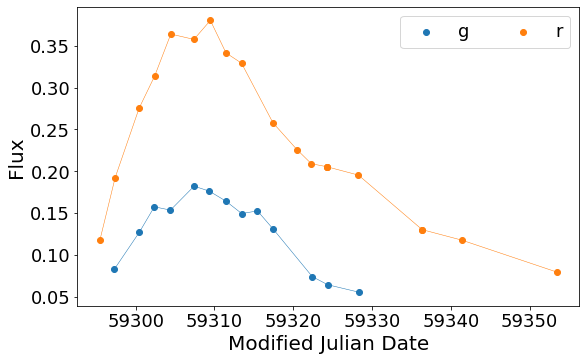

ZTF18aansqov


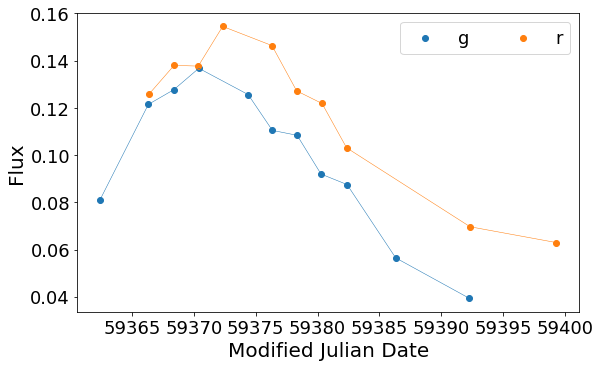

ZTF18aanygjk


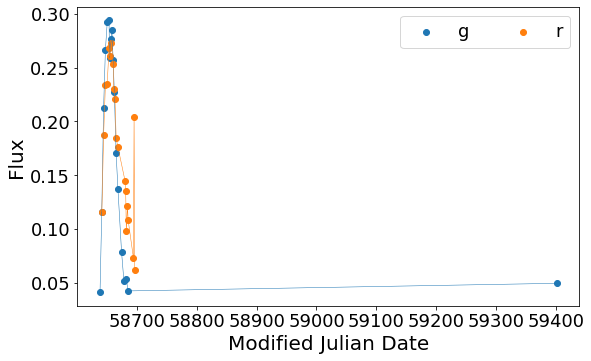

ZTF18aaoxrup


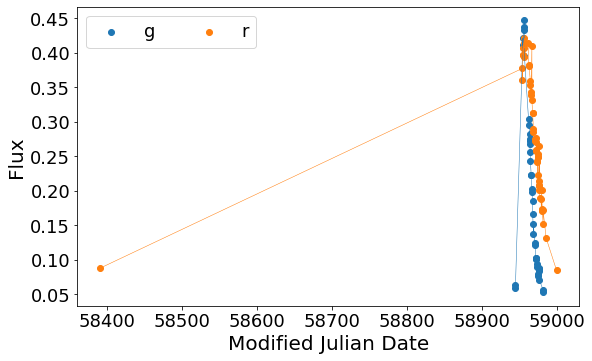

ZTF18aapictz


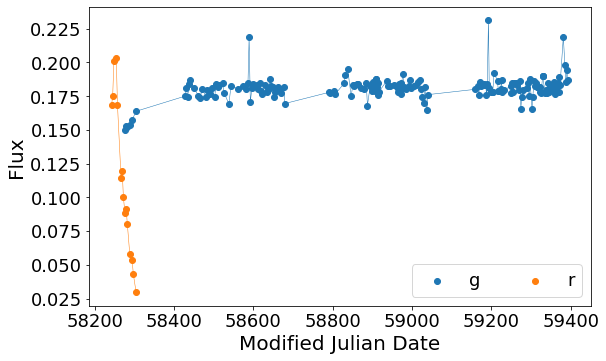

ZTF18aaqedfj


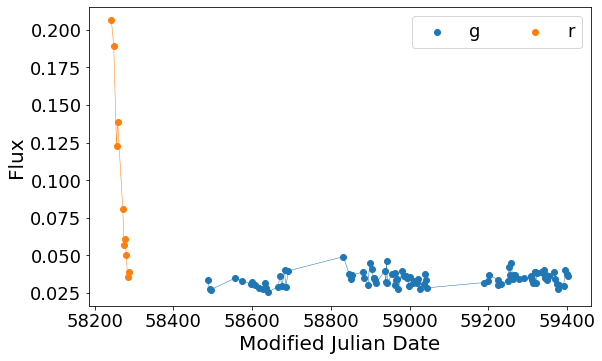

ZTF18aaqjovh


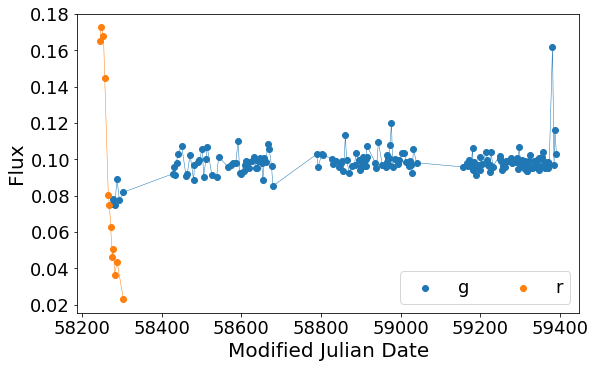

ZTF18aaqkcso


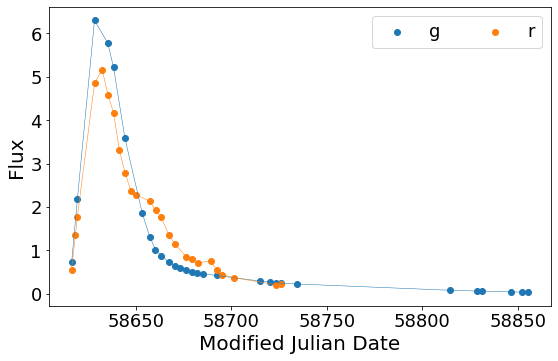

ZTF18aaqkdwu


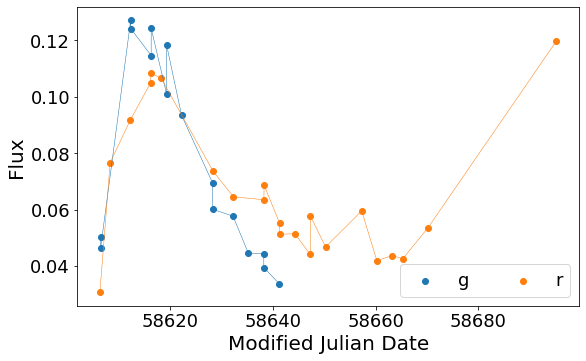

ZTF18aaqkoyr


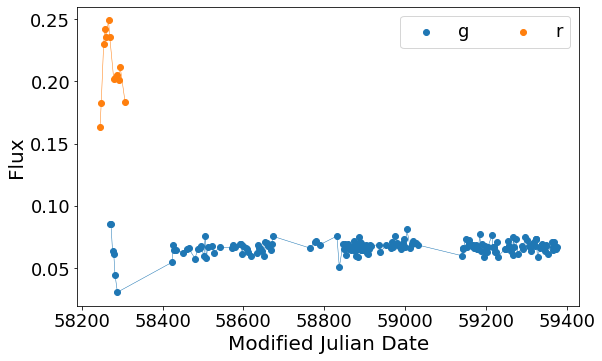

ZTF18aaqskoy


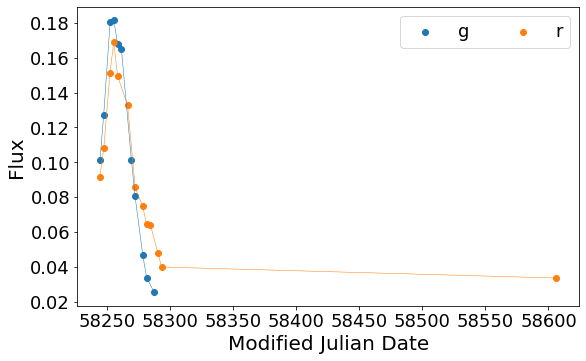

ZTF18aarbaba


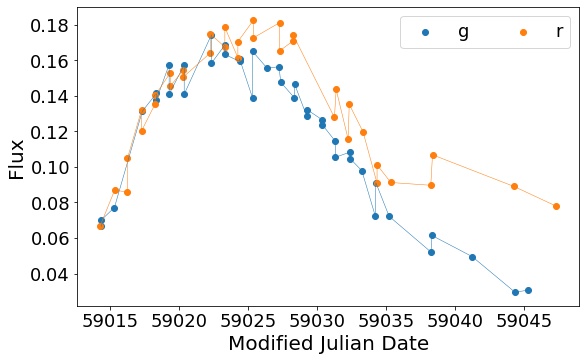

ZTF18aarikzk


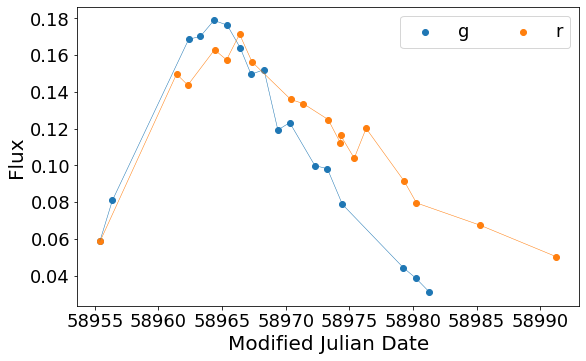

ZTF18aarlukc


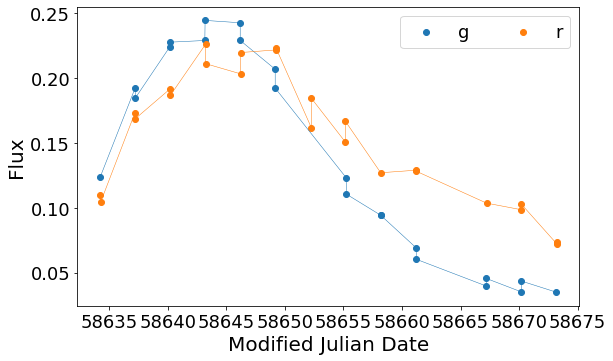

ZTF18aarwxum


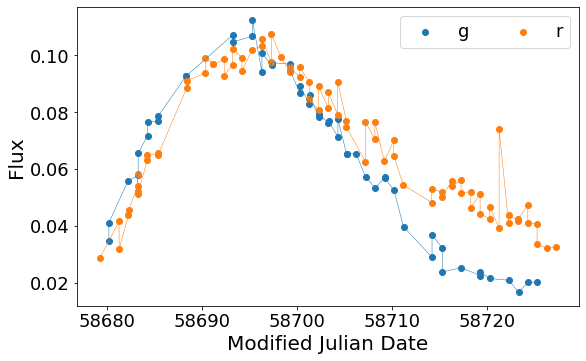

ZTF18aasdted


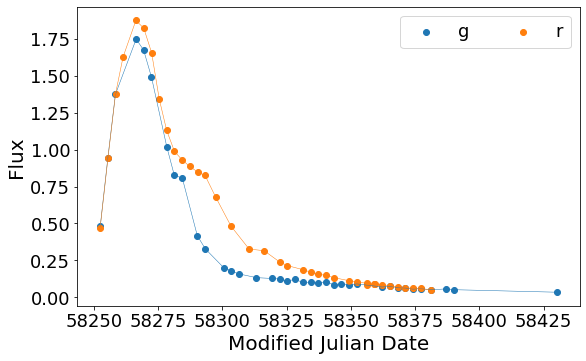

ZTF18aasxvsg


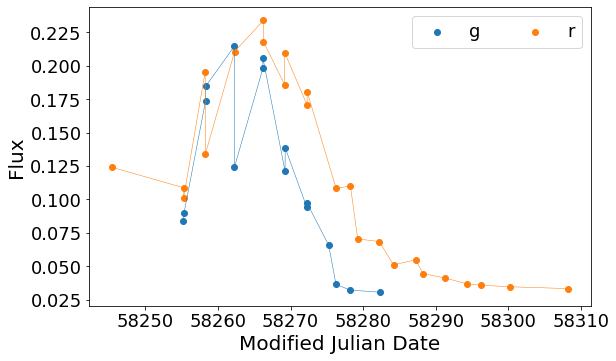

ZTF18aaszvfn


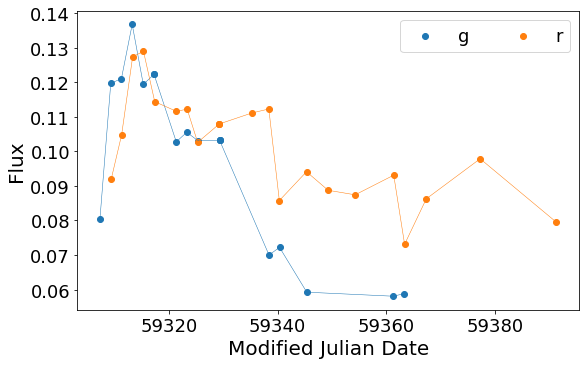

ZTF18aatgdph


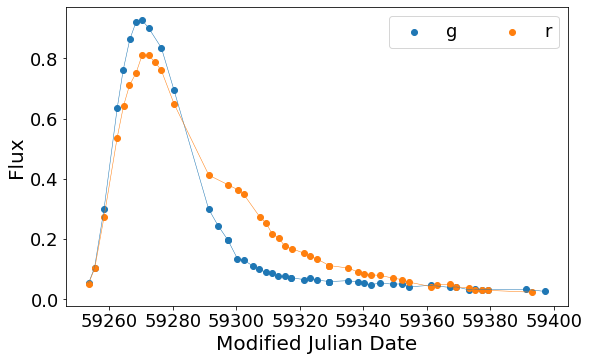

ZTF18aatlfus


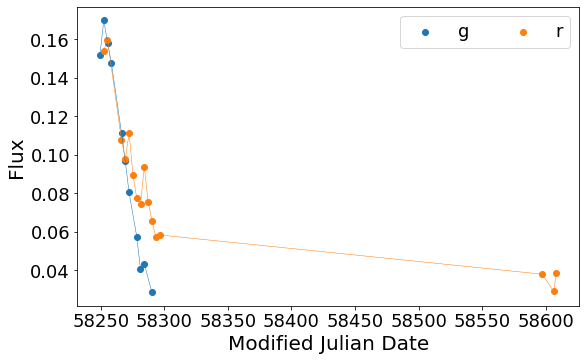

ZTF18aatrkga


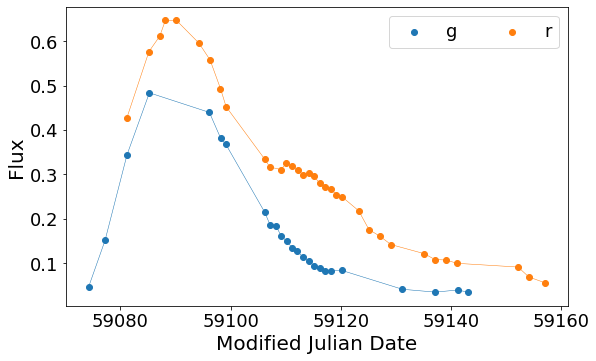

ZTF18aauizcr


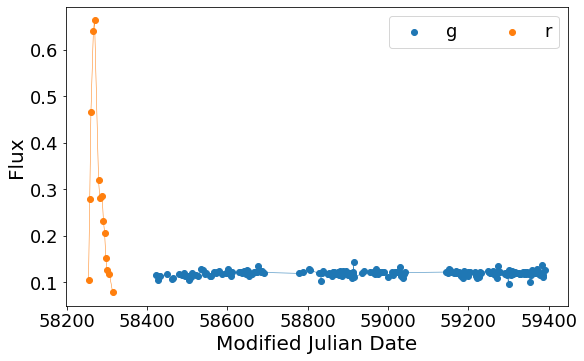

ZTF18aaumeys


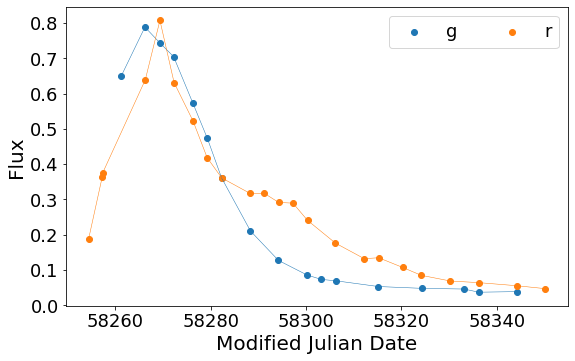

ZTF18aavqdyq


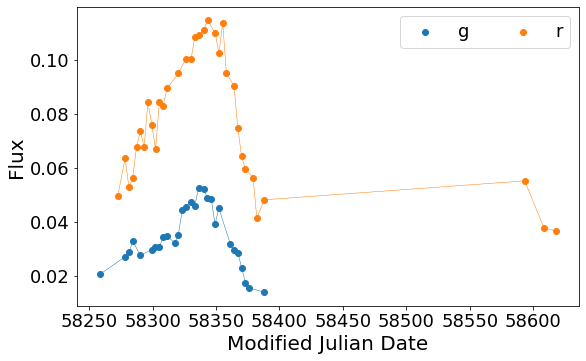

ZTF18aavrmlf


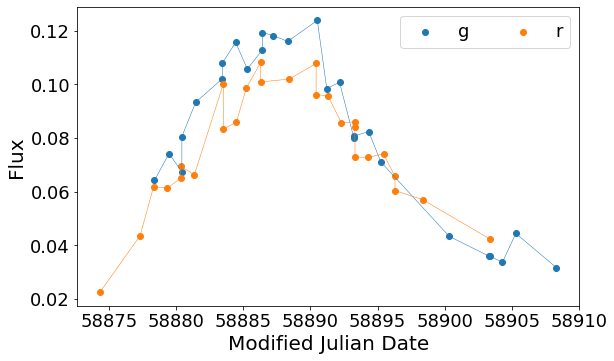

ZTF18aavrwhu


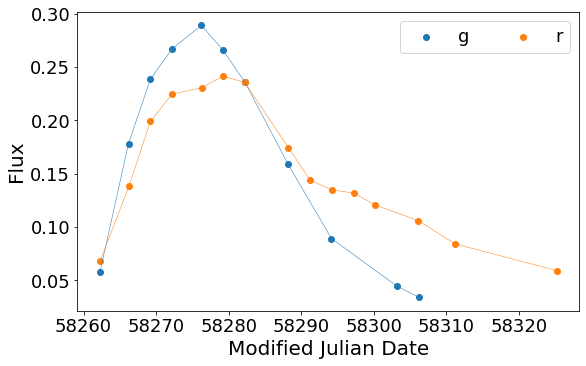

ZTF18aavvnzu


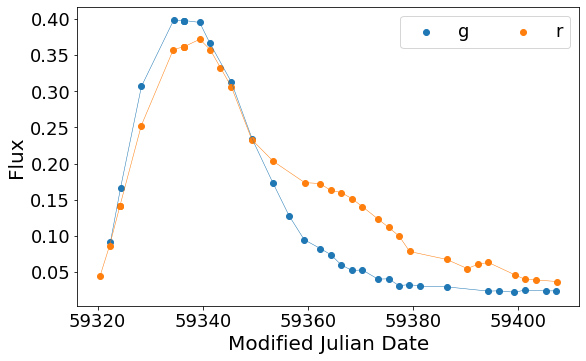

ZTF18aawgrxz


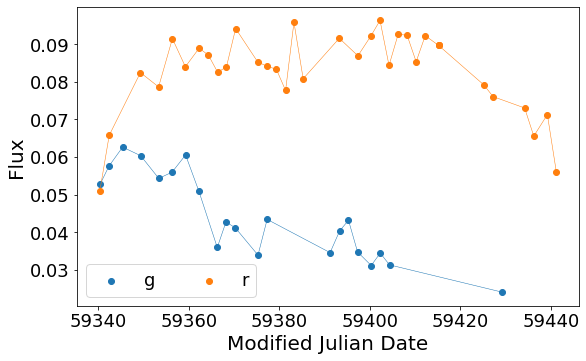

ZTF18aawpwlf


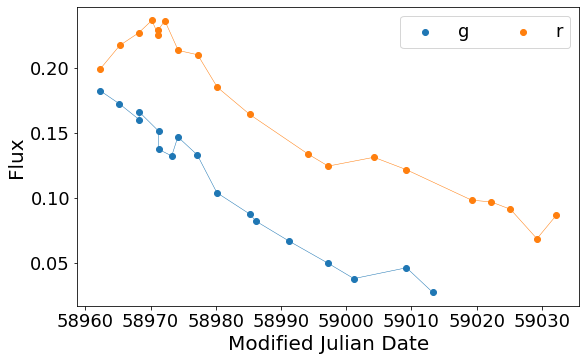

ZTF18aawyjjq


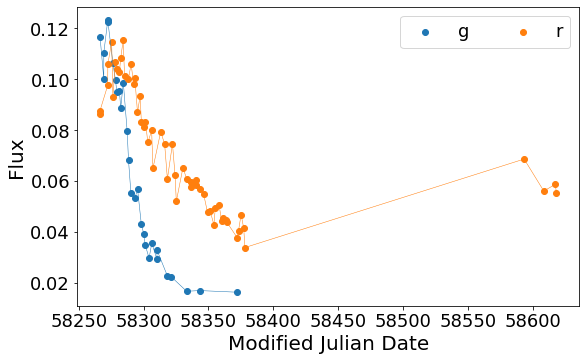

ZTF18aaxcntm


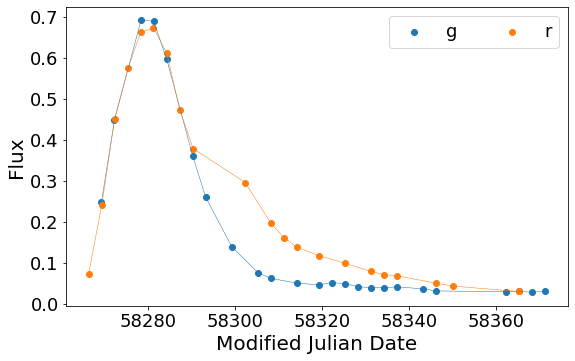

ZTF18aaxdrjn


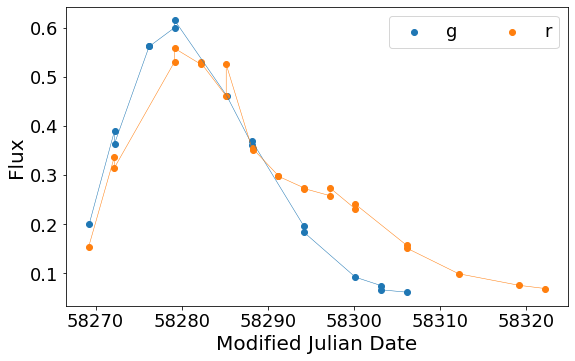

ZTF18aaxnqjb


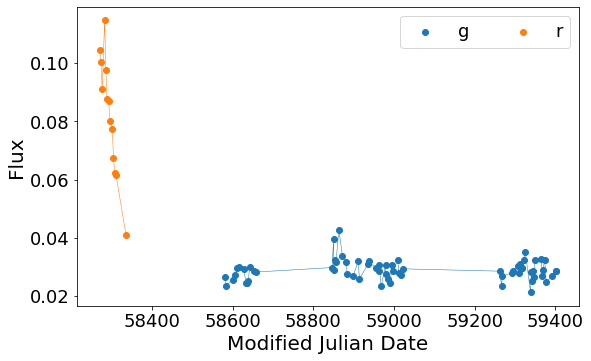

ZTF18aaxqyki


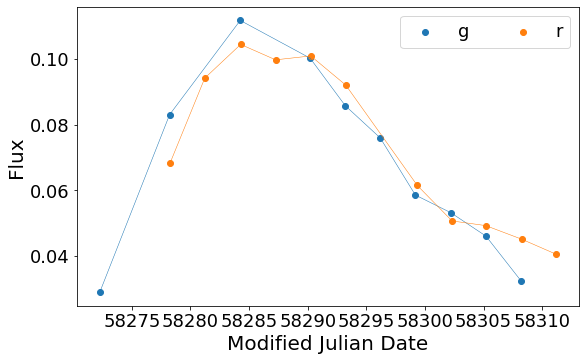

ZTF18aaxsioa


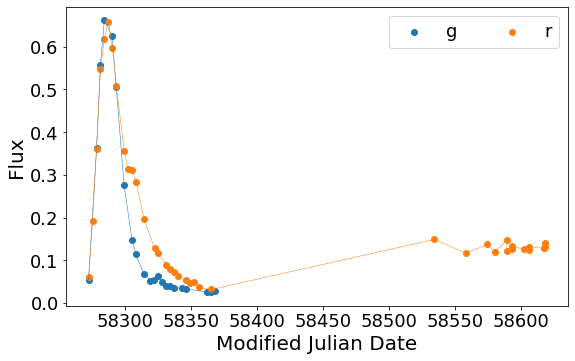

ZTF18aaxwjmp


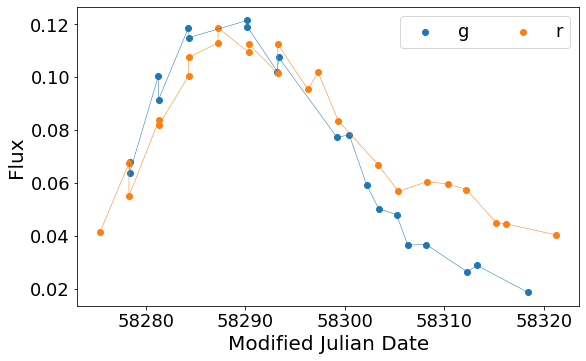

ZTF18aaybfsd


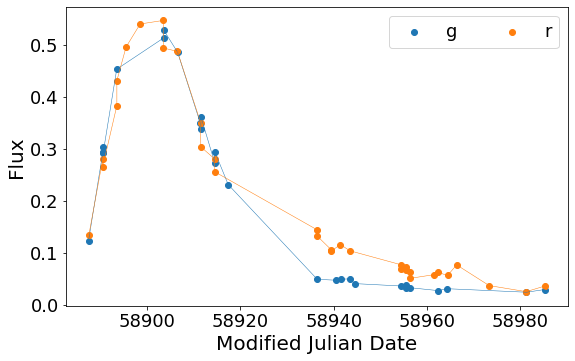

ZTF18aayjvve


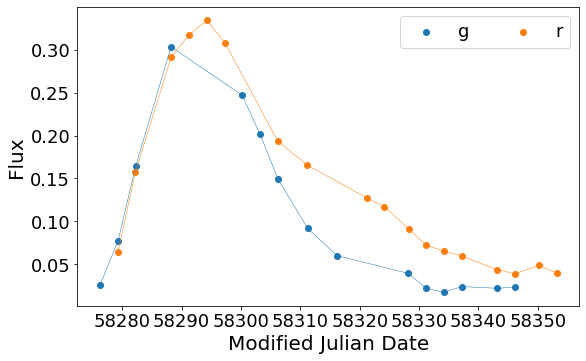

ZTF18aayjyub


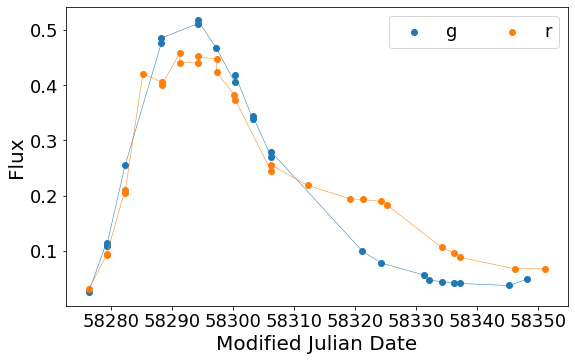

ZTF18aaykjei


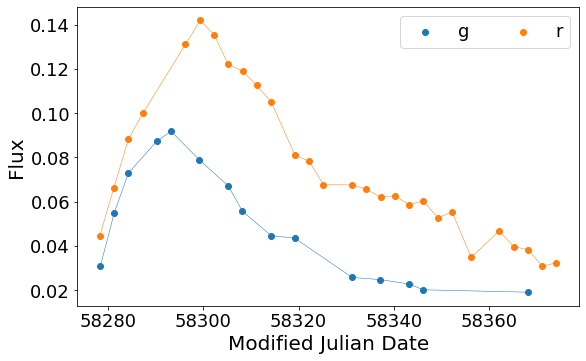

ZTF18aaytovs


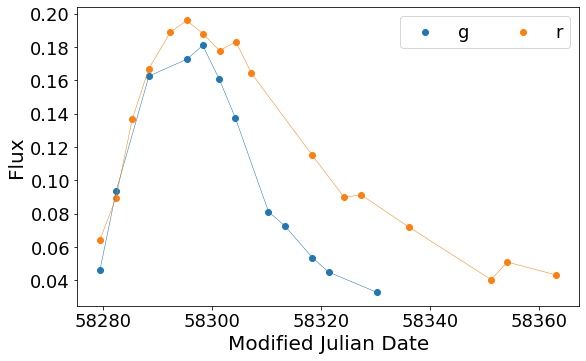

ZTF18aazblzy


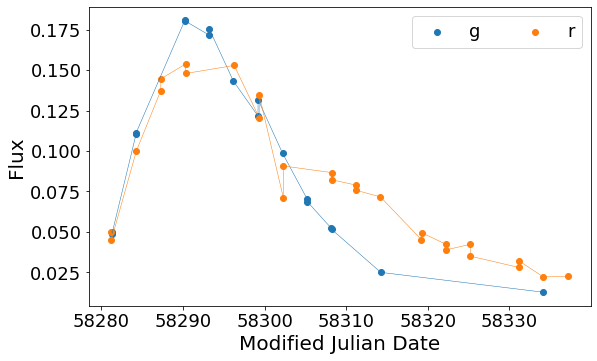

ZTF18aazsabq


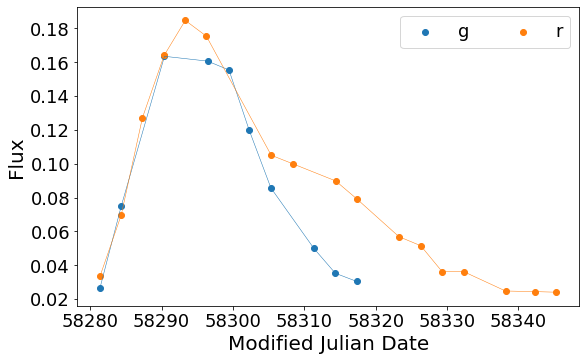

ZTF18abauprj


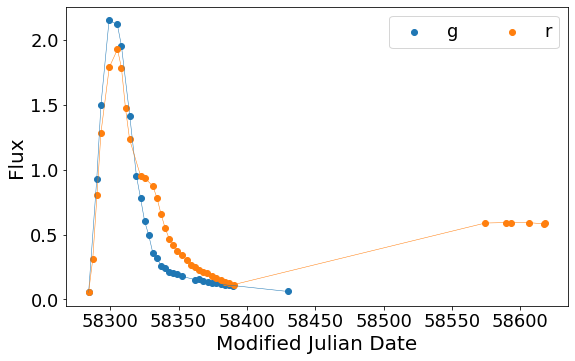

ZTF18abavruc


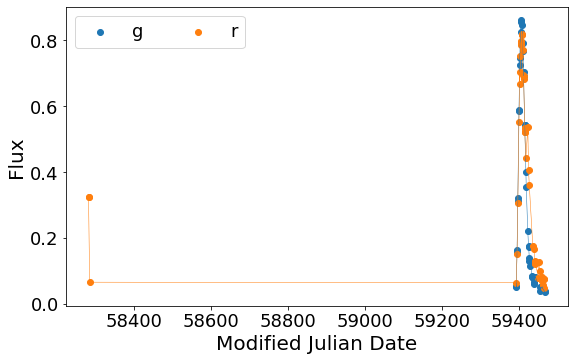

ZTF18abaxlpi


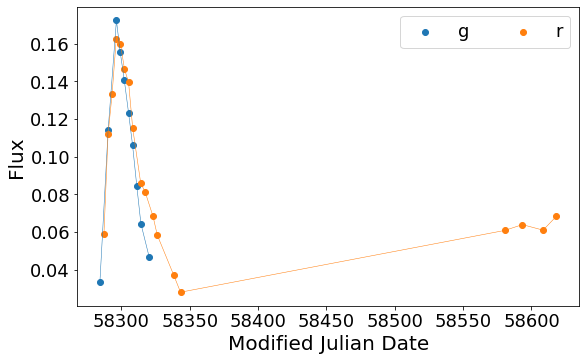

ZTF18abbpeqo


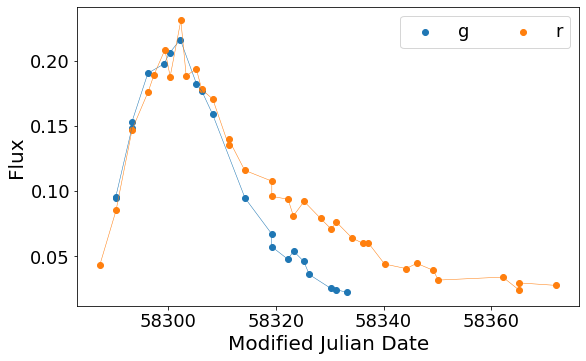

In [16]:
for i in object_ids[:100]:
    anobject = get_object(data, i)
    if not is_good(anobject):
        continue
    print(i)
    plot_light_curves(anobject)
    plt.show()

In [17]:
# for i in object_ids[200:300]:
#     anobject = get_object(data, i)
#     if not is_good(anobject):
#         continue
#     print(i)
#     plot_light_curves(anobject)
#     plt.show()

In [18]:
# ZTF17aaazdba !, ZTF18aarwxum, ZTF18aasdted, ZTF18aatgdph, ZTF18aatrkga !, 
# ZTF18aaykjei !, ZTF18abcfdzu !, ZTF18abfzfcv, ZTF18abokyfk
# ZTF18acbwaxk !, ZTF18acnnevs, ZTF20aahbamv !

# One object test Test

In [19]:
def plot_light_curves(anobject, title="", is_plot=True):
    anobject = anobject.sort_values('mjd')
    plt.figure(figsize=(9, 5))
    for passband in range(len(passband2name)):
        light_curve = get_passband(anobject, passband)
        if is_plot:
            plt.plot(light_curve['mjd'].values, light_curve['flux'].values, linewidth=0.5)
        plt.scatter(light_curve['mjd'].values, light_curve['flux'].values, label=passband2name[passband], linewidth=1)
    plt.xlabel('Modified Julian Date', size=20)
    plt.xticks(size=18)
    plt.ylabel('Flux', size=20)
    plt.yticks(size=18)
    plt.legend(loc='best', ncol=1, fontsize=20)
    plt.title(title, size=18)

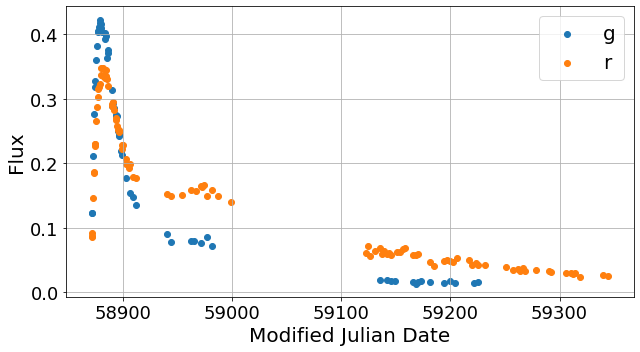

In [20]:
anobject = get_object(data, "ZTF20aahbamv") # ZTF17aaazdba, ZTF18aarwxum, ZTF18aasdted
anobject = add_log_lam(anobject)
#anobject['flux'] += 1*np.random.normal(0, anobject['flux_err'], len(anobject))

plot_light_curves(anobject, is_plot=False)
plt.grid()
#plt.ylim(-50, 1000)
plt.tight_layout()
plt.savefig('img/ZTF20aahbamv.pdf', format='pdf')
plt.savefig('img/ZTF20aahbamv.png', format='png')

In [21]:
def plot_light_curves_with_sigma(t, flux, flux_err, passband, title=""):
    colors = ['C'+str(i) for i in range(len(np.unique(passband)))]
    plt.figure(figsize=(9, 5))
    for i, pb in enumerate(np.unique(passband)):
        plt.plot(t[passband == pb], flux[passband == pb], linewidth=3., color=colors[i])
        plt.fill_between(t[passband == pb], 
                         flux[passband == pb]+1*flux_err[passband == pb], 
                         flux[passband == pb]-1*flux_err[passband == pb], 
                         label=passband2name[pb], alpha=0.5, color=colors[i])
    plt.xlabel('Modified Julian Date', size=20)
    plt.xticks(size=18)
    plt.ylabel('Flux', size=20)
    plt.yticks(size=18)
    plt.legend(loc='best', ncol=3, fontsize=18)
    plt.title(title, size=18)
    
def plot_points(anobject, title="", is_plot=True):
    anobject = anobject.sort_values('mjd')
    for passband in range(len(passband2name)):
        light_curve = get_passband(anobject, passband)
        plt.scatter(light_curve['mjd'].values, 
                    light_curve['flux'].values, s=20)
        
        

In [22]:
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, WhiteKernel, DotProduct, ConstantKernel as C

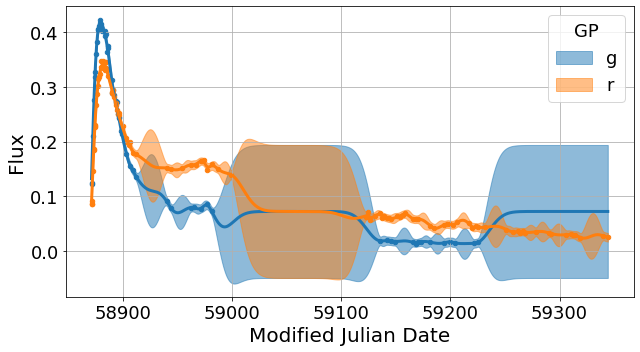

/Users/mikhail/opt/anaconda3/envs/fulu/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


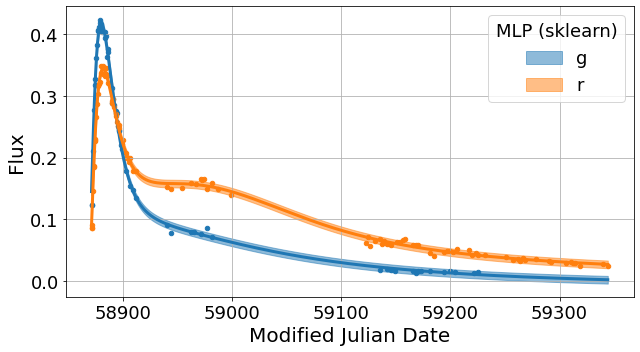

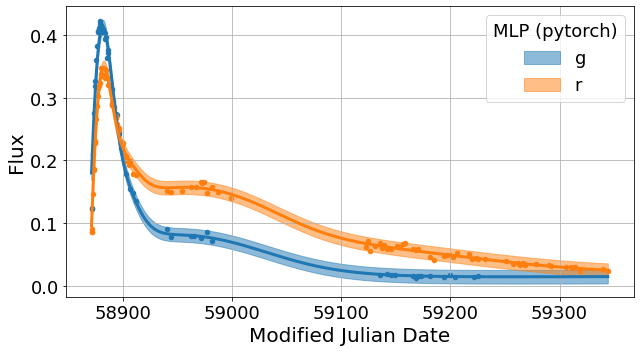

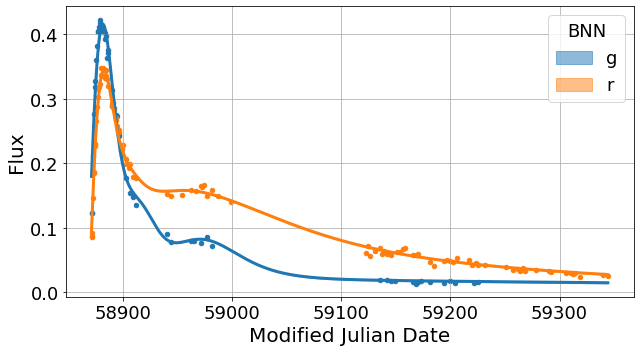

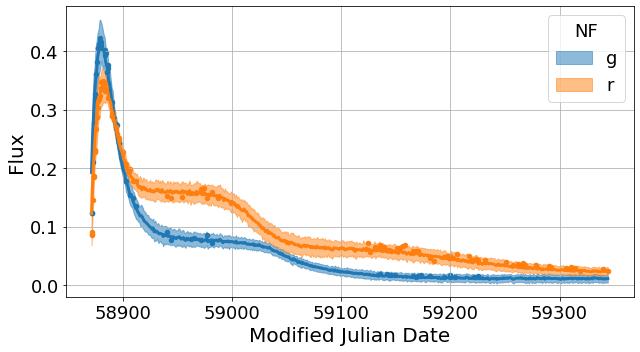

In [23]:
# train test split
t = anobject['mjd'].values
flux = anobject['flux'].values #+ np.random.normal(0, 30, len(t))
flux_err = anobject['flux_err'].values
passband = anobject['passband'].values

for mod in ['GP', 'MLP (sklearn)', 'MLP (pytorch)', 'BNN', 'NF']:
#for mod in ['MLP (sklearn)']:
    # approximation model
    if mod == 'GP':
        kernel = C(1.0) * Matern() * RBF([1, 1]) + Matern() + WhiteKernel()
        aug = fulu.GaussianProcessesAugmentation(passband2lam, kernel)
    elif mod == 'MLP (sklearn)':
        params = {'passband2lam': passband2lam, 
                              'hidden_layer_sizes': (20, 10),
                              'solver': 'lbfgs',
                              'activation': 'tanh',
                              'learning_rate_init': 0.03171745,
                              'max_iter': 9000, 
                              'batch_size': 1000, 
                              'weight_decay': 0.03109669}
        aug = fulu.MLPRegressionAugmentation(**params)
    elif mod == 'MLP (pytorch)':
        params = {'passband2lam': passband2lam, 
          'n_hidden': 20, 
          'activation': 'tanh', 
          'n_epochs': 10000, 
          'batch_size': 500, 
          'lr': 0.1, 
          'optimizer': 'Adam', 
          'device': 'auto', 
          'weight_decay': 0.00001}
        aug = fulu.SingleLayerNetAugmentation(**params)
    elif mod == 'BNN':
        params = {'passband2lam': passband2lam, 
                          'n_hidden': 50, 
                          'prior_sigma': 0.1, 
                          'n_epochs': 10000, 
                          'lr': 0.05, 
                          'kl_weight': 0.00001, 
                          'optimizer': 'Adam', 
                          'device': 'cpu', 
                          'weight_decay': 0.00000}
        aug = fulu.BayesianNetAugmentation(**params)
    elif mod == 'NF':
        params = {'passband2lam': passband2lam, 
                  'batch_size': 500, 
                  'n_epochs': 10000, 
                  'lr': 0.0500001, 
                  'device': 'cpu', 
                  'weight_decay': 0.}
        aug = fulu.NormalizingFlowAugmentation(**params)
    
    aug.fit(t, flux, flux_err, passband)

    # augmentation
    t_aug, flux_aug, flux_err_aug, passband_aug= aug.augmentation(t_min=t.min(), t_max=t.max(), n_obs=512)


    # plotting
    plot_light_curves_with_sigma(t_aug, flux_aug, flux_err_aug, passband_aug, title="")
    plot_points(anobject, title="", is_plot=True)
    #plt.scatter(t, flux, label='Observations', color='0.4', s=10)
    leg = plt.legend(loc='best', ncol=1, fontsize=18, title=mod)
    leg.get_title().set_fontsize('18')
    plt.grid()
    plt.tight_layout()
    plt.savefig('img/ZTF20aahbamv_%s.pdf' % (mod), format='pdf')
    plt.savefig('img/ZTF20aahbamv_%s.png' % (mod), format='png')
    plt.show()

In [24]:
def compile_obj(t, flux, flux_err, passband):
    obj = pd.DataFrame()
    obj['mjd']      = t
    obj['flux']     = flux
    obj['flux_err'] = flux_err
    obj['passband'] = passband
    return obj

def direct_peak_estimation(images, timestamps):
    peak_pred = []
    for i in range(len(images)):
        img = images[i]
        ts = timestamps[i]
        peak_pred.append(ts[img.sum(axis=0).argmax()])
    return np.array(peak_pred)

In [25]:
# ZTF17aaazdba !, ZTF18aarwxum, ZTF18aasdted, ZTF18aatgdph, ZTF18aatrkga !, 
# ZTF18aaykjei !, ZTF18abcfdzu !, ZTF18abfzfcv, ZTF18abokyfk
# ZTF18acbwaxk !, ZTF18acnnevs, ZTF20aahbamv !

ZTF18aatgdph


/Users/mikhail/opt/anaconda3/envs/fulu/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


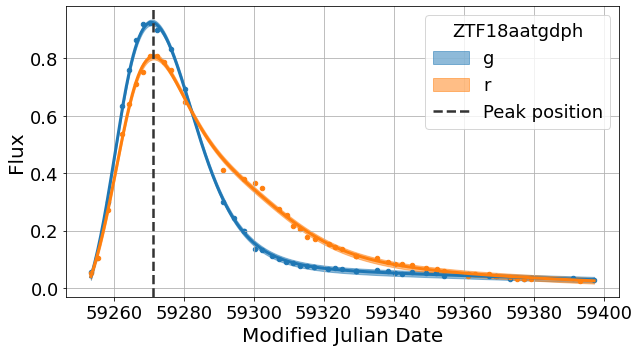

ZTF18aaykjei


/Users/mikhail/opt/anaconda3/envs/fulu/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


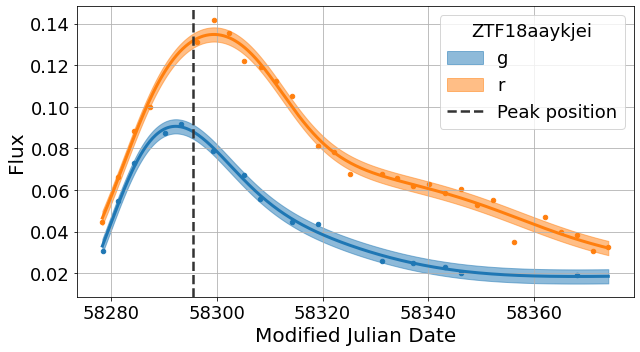

ZTF18abcfdzu


/Users/mikhail/opt/anaconda3/envs/fulu/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


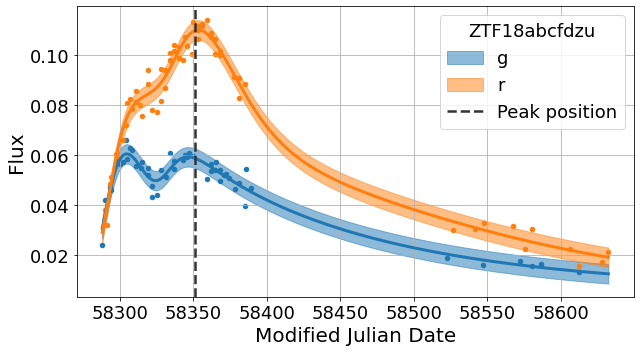

ZTF18acbwaxk


/Users/mikhail/opt/anaconda3/envs/fulu/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


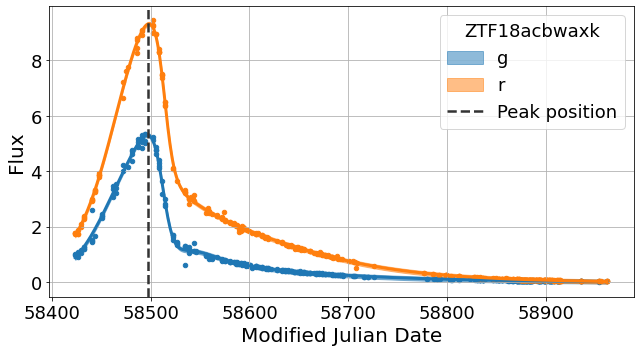

ZTF18acnnevs


/Users/mikhail/opt/anaconda3/envs/fulu/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


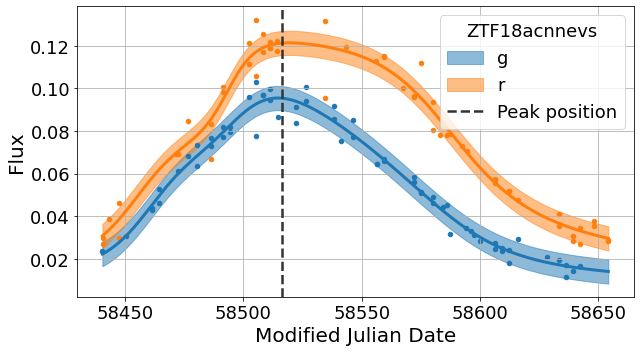

ZTF18aawgrxz


/Users/mikhail/opt/anaconda3/envs/fulu/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


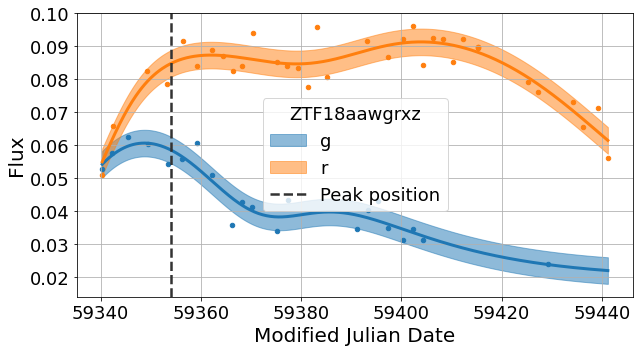

In [26]:
objs = ['ZTF17aaazdba', 'ZTF18aarwxum', 'ZTF18aasdted', 'ZTF18aatgdph', 'ZTF18aatrkga', 
        'ZTF18aaykjei', 'ZTF18abcfdzu', 'ZTF18abfzfcv', 'ZTF18abokyfk', 'ZTF18acbwaxk', 
        'ZTF18acnnevs', 'ZTF20aahbamv', 'ZTF18aawgrxz', 'ZTF18aawpwlf']

objs2 = ['ZTF18aatgdph', 'ZTF18aaykjei', 'ZTF18abcfdzu', 'ZTF18acbwaxk', 
         'ZTF18acnnevs', 'ZTF18aawgrxz']

for i in objs2:
    
    print(i)
    
    anobject = get_object(data, i) # ZTF17aaazdba, ZTF18aarwxum, ZTF18aasdted
    anobject = add_log_lam(anobject)
    
    # train test split
    t = anobject['mjd'].values
    flux = anobject['flux'].values #+ np.random.normal(0, 30, len(t))
    flux_err = anobject['flux_err'].values
    passband = anobject['passband'].values
    
    params = {'passband2lam': passband2lam, 
                              'hidden_layer_sizes': (20, 10),
                              'solver': 'lbfgs',
                              'activation': 'tanh',
                              'learning_rate_init': 0.03171745,
                              'max_iter': 9000, 
                              'batch_size': 1000, 
                              'weight_decay': 0.03109669}
    aug = fulu.MLPRegressionAugmentation(**params)
    #aug = fulu.GaussianProcessesAugmentation(passband2lam)
    
    aug.fit(t, flux, flux_err, passband)

    # augmentation
    t_aug, flux_aug, flux_err_aug, passband_aug= aug.augmentation(t_min=t.min(), t_max=t.max(), n_obs=512)

    # convert values to 2D-array
    anobject_aug = compile_obj(t_aug, flux_aug, flux_err_aug, passband_aug)
    anobject_aug = anobject_aug.drop('flux_err', axis=1).set_index(['mjd', 'passband']).unstack(level=1)
    data_array = anobject_aug.values.T
    timestamps = np.array(anobject_aug.index)
    
    peak = direct_peak_estimation([data_array], [timestamps])[0]
    
    # plotting
    plot_light_curves_with_sigma(t_aug, flux_aug, flux_err_aug, passband_aug, title="")
    plot_points(anobject, title="", is_plot=True)
    #plt.scatter(t, flux, label='Observations', color='0.4', s=10)
    xmin, xmax, ymin, ymax = plt.axis()
    
    plt.plot([peak, peak], [ymin, ymax], '--', linewidth=2.5, color='0.2', label='Peak position')
    plt.ylim(ymin, ymax)
    leg = plt.legend(loc='best', ncol=1, fontsize=18, title=i)
    leg.get_title().set_fontsize('18')
    plt.grid()
    plt.tight_layout()
    plt.savefig('img/%s_peak.pdf' % (i), format='pdf')
    plt.savefig('img/%s_peak.png' % (i), format='png')
    plt.show()